In [3]:
%load_ext autoreload
%autoreload 2
import synthetics
import waveform_tools
import matplotlib.pyplot as plt
import numpy as np
import scipy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dev notebook to sort out the negative frequency bugs in waveform_tools.

First generate a waveform with no dt* (and no frequency domain operations)

dt* = 0


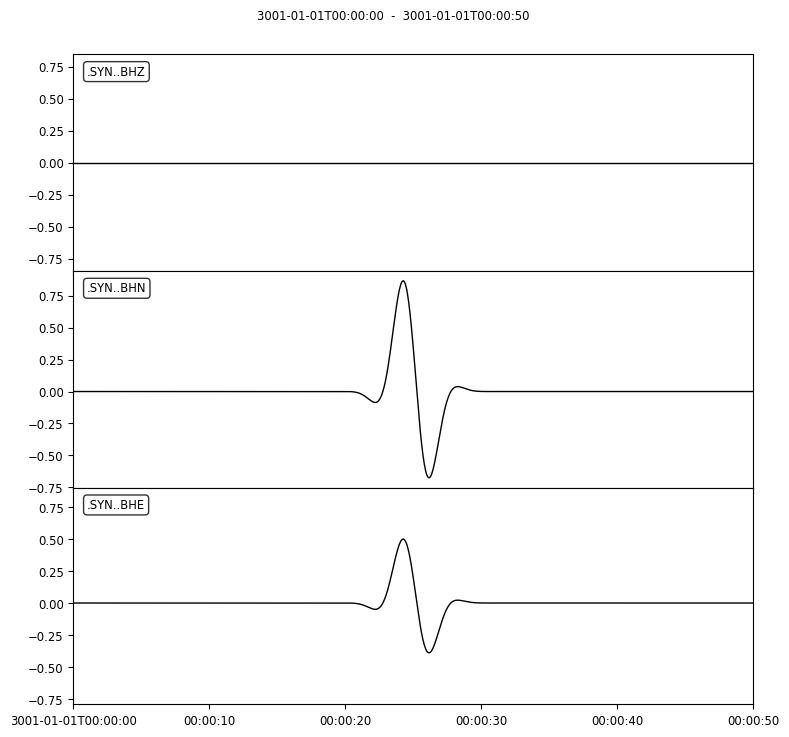

0.05

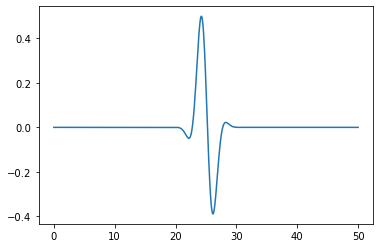

In [39]:
test = synthetics.gen_synthetic_split(30, 1.5, dtstar=0)
# Isolate one trace
test.plot()
tr = test[1].data
time = test[1].times()
plt.plot(time, tr)
test[0].stats.delta

Apply the interal dtstar function from wavefrom tools with NO dt*
This should not modify the waveform at all!

In [40]:
tr_out = waveform_tools.apply_tstar(tr, fref=1, delta=0.05, tstar=1)

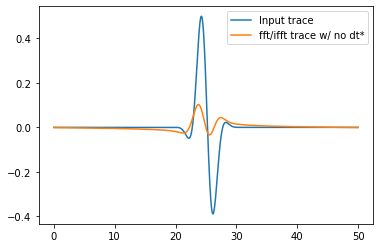

In [41]:
fig, ax = plt.subplots(1,1)
ax.plot(time, tr, label='Input trace')
ax.plot(time, tr_out, label='fft/ifft trace w/ no dt*')
ax.legend()
plt.show()

Here is the bug, we are NOT getting out what we put in for the fft and ifft
Lets pull apart the code from apply_tstar and make sure the negative frequencies are being handled properly (spolier - they aren't atm)

In [7]:
signal = tr.copy()
delta = 0.05
fref = 1
tstar = 0 
from scipy.fft import fft, ifft, fftfreq, next_fast_len
# Copy of the bugged version of apply_tstar, without the causual attenuation operator for now
# Take fft of trace. Supplying a larger n 0-pads trace.

nsamps = len(signal)
n = next_fast_len(nsamps)
fd_signal = fft(signal, n)
frequencies = fftfreq(n, d=delta)[0:n//2]
#Negative frequencies are in second half of array     

#get angular frequencies
ang_freqs = 2*np.pi*frequencies
ang_fref = 2*np.pi*fref
# Create causual t* multiplier 
aw_imag = (-1j)*(1/np.pi) * tstar * ang_freqs[1:] * np.log((ang_freqs[1:])/ang_fref)
aw_real = (-1/2)*ang_freqs[1:]*tstar
aw = np.ones(n//2, dtype=np.complex128())
aw[1:] = np.exp(aw_real + aw_imag)
# Apply t* operate to frequency domain signal
attenuated_fd_signal = np.zeros((int(n),), dtype=np.complex128())
attenuated_pos_f = fd_signal[0:n//2]*aw
attenuated_fd_signal[0:n//2] = attenuated_pos_f
# Restore symettry for negative frequencies
# index pos frequencies from 1 as we don't need to repeate f=0
attenuated_neg_f = np.conjugate(attenuated_pos_f[1:])
# index from [n//2+1] following scipy docs. if n is even then +/- nyquist frewquencies
# are aliased together
attenuated_fd_signal[n//2+1:] = np.flip(attenuated_neg_f)
# Take inverse fft
attenuated_signal = ifft(attenuated_fd_signal, nsamps)

In [8]:
f = fftfreq(n, delta)
f[n//2]


-10.0

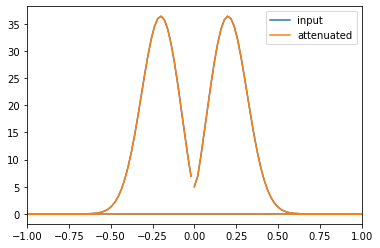

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(f, abs(fd_signal), label='input')
ax.plot(f, abs(attenuated_fd_signal), label='attenuated')
ax.set_xlim([-1,1])
ax.legend()

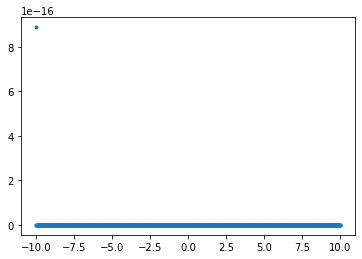

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(f, abs(fd_signal) - abs(attenuated_fd_signal),'.')


In [11]:
fd_signal[0]

(5.030722496188454-0j)

Now try generating attenuated synthetics

dt* = 0


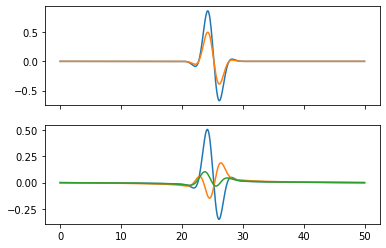

In [66]:
syn1 = synthetics.gen_synthetic_split(30, 1, dtstar=0, npts=501)
syn2 = synthetics.gen_synthetic_split(30, 1, dtstar=1, npts=501)
# Now try to reproduce the dtstar manually
synm = waveform_tools.apply_tstar(syn1[1], 1, 1, 0.05)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(syn1[0].times(), syn1[0].data,
         syn1[1].times(), syn1[1].data)
ax2.plot(syn2[0].times(), syn2[0].data,
         syn2[1].times(), syn2[1].data,
         syn2[1].times(), synm)



In [56]:
syn1[0].stats

         network: 
         station: SYN
        location: 
         channel: BHN
       starttime: 3001-01-01T00:00:00.000000Z
         endtime: 3001-01-01T00:00:50.000000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 1001
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.05, 'b': -25.0, 'e': 25.0, 'baz': 30, 'evla': 0, 'evlo': 0, 'evdp': 500, 'stlo': 0, 'stla': 80, 'kstnm': 'SYN', 'a': -10.0, 'f': 10.0, 'user0': -10.0, 'user2': 10.0, 'cmpaz': 0, 'cmpinc': 90, 'cmpnm': 'BHN'})

.SYN..BHN | 3001-01-01T00:00:00.000000Z - 3001-01-01T00:00:50.000000Z | 20.0 Hz, 1001 samples